In [1]:
import string
import numpy as np
import pandas as pd
import nltk
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from HappyFunTokenizer import HappyFunTokenizer
from sklearn_pandas import DataFrameMapper
import os 
import spacy

## Preprocessing

In [88]:
def get_rel_path(file_name):
    absolutepath = os.path.abspath('')
    #print(absolutepath)
    fileDirectory = os.path.dirname(absolutepath)
    file_path = os.path.join(fileDirectory, 'Data/ExtraCredit/' + str(file_name))   
    #print(file_path)
    return file_path

In [90]:
# load files
# read in files from folder 
file_path = get_rel_path("Yelp/all_reviews.txt")
file = open(file_path, "r")
lines = file.readlines()

In [53]:
neg_reviews = [] #contains 1star - 3star reviews (N = 4325)
pos_reviews = [] # contains 4star - 5star reviews  (N = 6066)

new_rating = "{{{"
start_of_review = "[[["
end_of_review = "]]]"
end_rating = "}}}"
rating = 0 # 0 = negative; 1 = positive 
in_review = False
review = "" #holds 1 review at a time 
for i, line in enumerate(lines):
    tokens = line.split()
    if tokens: #if list is NOT empty 
        if len(tokens) == 1: #IF SINGLE TOKEN IN LINE 
            #print(i, " ", tokens)
            if tokens[0] == new_rating or tokens[0] == end_rating:
                #print("\t===new/end rating")
                continue
            elif tokens[0] == "1star" or tokens[0] == "2star" or tokens[0] == "3star": 
                rating = 0 
                #print("\tnegative rating, :", rating, " ", tokens[0])
                continue 
            elif tokens[0] == "4star" or tokens[0] == "5star": 
                rating = 1 
                #print("\tpositive rating:", rating)
                continue
            elif tokens[0] == end_of_review: 
                if rating == 0: neg_reviews.append(review)   #ADD FULL REVIEW TO RESPECTIVE LIST
                else: pos_reviews.append(review)
                in_review = False 
                #print("\t--end of review")
                continue  
            elif tokens[0] == start_of_review:
                in_review = True
                review = "" 
                #print("\t--starting new review")
                continue
            else:                               # SOME REVIEWS HAVE SINGLE LINES W/ 1 WORD: ADD THESE TO REVIEW
                review = review + tokens[0] 
        else:  # IF MULTIPLE TOKENS IN LINE 
            if in_review == True: 
                review = review + " ".join(tokens)

## Feature: Negation

In [55]:
# Sentiment aware tokenization + negation 
neg_reviews_tokens = []
pos_reviews_tokens = []
tokenizer = HappyFunTokenizer()
        
for review in neg_reviews:
    tokens = tokenizer.tokenize(review, negation = True)
    neg_reviews_tokens.append(tokens)

for review in pos_reviews:
    tokens = tokenizer.tokenize(review, negation = True)
    pos_reviews_tokens.append(tokens)

print(len(neg_reviews_tokens))
print(len(pos_reviews_tokens))
all_reviews_tokens = pos_reviews_tokens + neg_reviews_tokens
print(len(all_reviews_tokens))

4325
6066
10391


In [56]:
# make dataframe 
sentiment = ([1] * len(pos_reviews)) + ([0] * len(neg_reviews)) # sentiment labels 
data = {'Sentiment': sentiment, 'Review': all_reviews_tokens}
df_data = pd.DataFrame(data)
df_data.describe()

,Sentiment
count,10391.000000
mean,0.583774
std,0.492956
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [77]:
df_data.head(n=4)

,Sentiment,Review
0,1,"[my, kid, begged, me, to, give, desthil, anoth..."
1,1,"[good, variety, of, menu, items, ., brewed, on..."
2,1,"[tasty, food, ,, solid, drink, selection, ,, a..."
3,1,"[service, was, stellar, ., the, waiter, was, v..."


In [57]:
def dummy_fun(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    min_df=2, 
    #max_df = 0.8, 
    use_idf =True,
    smooth_idf=True,
    sublinear_tf = True,
    )

In [58]:
tfidf_reviews = tfidf_vectorizer.fit_transform(df_data.loc[:, 'Review'])
print("n_samples: %d, n_features: %d" % tfidf_reviews.shape)
tfidf_reviews

n_samples: 10391, n_features: 14555


<10391x14555 sparse matrix of type '<class 'numpy.float64'>'
	with 812924 stored elements in Compressed Sparse Row format>

In [59]:
df_features = pd.DataFrame(tfidf_reviews.toarray())
df_features["Sentiment"] = df_data["Sentiment"]
df_features

,0,1,2,3,4,5,6,7,8,9,...,14546,14547,14548,14549,14550,14551,14552,14553,14554,Sentiment
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.144283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.047641,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.046755,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10387,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10388,0.000000,0.094669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10389,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Feature: Pos:Neg word ratio

In [62]:
def get_posneg_ratio(df):
    # import sentiment lexicon from csv 
    sentiment_lex = pd.read_csv('sentiment_lexicon.csv')
    # convert dataframe to dictionary for faster lookup 
    sentiment_lex = sentiment_lex.set_index('Word').T.to_dict("list") 
    ratios = []

    for index in range(len(df)):
        neg_count, pos_count = 0, 0
        neg = False 
        #tokens = df.loc[index, 'Review'].split()
        for token in df.loc[index, 'Review']:
            if "_NEG" in token: 
                token = token.replace("_NEG", "")
                neg = True
            sentiment = sentiment_lex.get(token)
            if sentiment == None:
                pos_count = pos_count
                neg_count = neg_count
                continue
            elif sentiment[0] == 1:
                if neg is True: neg_count = neg_count +1
                else: pos_count = pos_count +1
            elif sentiment[0] == 0:
                if neg is True: pos_count = pos_count +1
                else: neg_count = neg_count +1
        if neg_count == 0: ratios.append(None)
        else:
            ratios.append(pos_count / neg_count) 
    return ratios 

In [73]:
ratios = np.array(get_posneg_ratio(df_data), dtype=np.float64)
print("Sum", np.nansum(ratios), " Mean", np.nanmean(ratios))
df_features['Pos:Neg Ratio'] = ratios 
df_features

Sum 47266.64410330274  Mean 5.382831579922872


,0,1,2,3,4,5,6,7,8,9,...,14547,14548,14549,14550,14551,14552,14553,14554,Sentiment,Pos:Neg Ratio
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.650000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2,0.000000,0.144283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,26.000000
3,0.047641,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.042553
4,0.046755,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,27.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.666667
10387,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN
10388,0.000000,0.094669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.812500
10389,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.800000


<AxesSubplot:xlabel='Pos:Neg Ratio', ylabel='Count'>

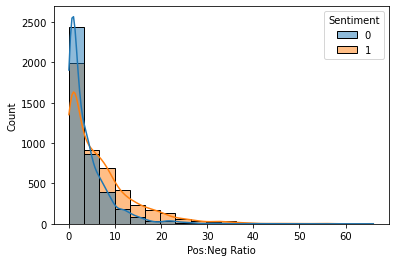

In [76]:
import seaborn as sns
sns.histplot(data = df_features, x = 'Pos:Neg Ratio', bins = 20, kde = True, hue = 'Sentiment')

## Feature: Review Length

In [78]:
def get_length(df):
    review_size = []
    for index in range(len(df)):
        review = df.loc[index, 'Review']
        review_size.append(len(review))
 
    return review_size

In [79]:
length = np.array(get_length(df_data), dtype=np.float64)
print("Sum", np.nansum(length), " Mean", np.nanmean(length))
df_features["Length"] = length
df_features

Sum 1323046.0  Mean 127.32614762775479


,0,1,2,3,4,5,6,7,8,9,...,14548,14549,14550,14551,14552,14553,14554,Sentiment,Pos:Neg Ratio,Length
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.650000,139.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,14.0
2,0.000000,0.144283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,26.000000,92.0
3,0.047641,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.042553,326.0
4,0.046755,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,27.000000,126.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.666667,171.0
10387,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,27.0
10388,0.000000,0.094669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.812500,190.0
10389,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.800000,82.0


Length: raw counts


<AxesSubplot:xlabel='Length', ylabel='Count'>

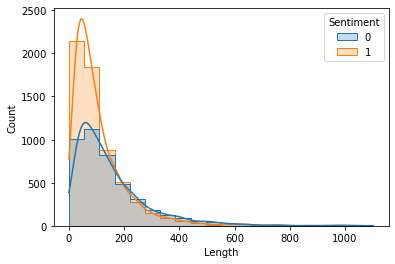

In [80]:
print("Length: raw counts")
sns.histplot(data = df_features, x = 'Length',bins = 20, kde = True, hue = 'Sentiment', element = 'step')

## Dependency parsing: Noun Phrases

In [81]:
from spacy.symbols import ADJ, VERB, NOUN
from nltk.tokenize import sent_tokenize

In [82]:
nlp = spacy.load("en_core_web_sm")
reviews = df_data["Review"].values
noun_chunks = [] 
for review in reviews:
    r = " ".join(review)
    r = r.replace("_NEG", "")
    sentences = sent_tokenize(r)
    chunk_count = 0
    #print("-------new review")
    for sentence in sentences:
        #print("--new sentence")
        doc = nlp(sentence)
        chunks = doc.noun_chunks
        for chunk in chunks: chunk_count = chunk_count + 1
    noun_chunks.append(chunk_count)

In [84]:
df_features["Noun Phrases"] = noun_chunks

<AxesSubplot:xlabel='Noun Phrases', ylabel='Count'>

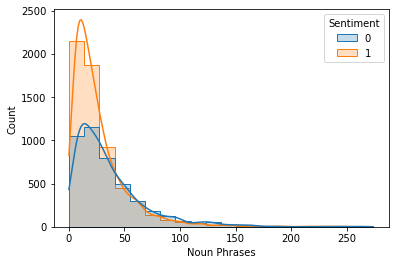

In [85]:
sns.histplot(data = df_features, x = 'Noun Phrases',bins = 20, kde = True, hue = 'Sentiment', element = 'step')

In [86]:
df_features

,0,1,2,3,4,5,6,7,8,9,...,14549,14550,14551,14552,14553,14554,Sentiment,Pos:Neg Ratio,Length,Noun Phrases
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.650000,139.0,31
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,14.0,4
2,0.000000,0.144283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,26.000000,92.0,26
3,0.047641,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.042553,326.0,75
4,0.046755,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,27.000000,126.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4.666667,171.0,45
10387,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,27.0,6
10388,0.000000,0.094669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.812500,190.0,49
10389,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2.800000,82.0,21


## Export to csv

In [87]:
file_path = get_rel_path("data_extracredit.csv")
df_features.to_csv(file_path, index = False)